# 教師あり学習(分類Ⅰ)
2021/10/23 ver.  


## 分類問題とは

分類問題とは、データがどのクラス（カテゴリ）に属するかを予測する問題です。  
たとえば、ある銀行で行われた定期預金商品のキャンペーンについてのデータセットを使って、顧客が「契約する（正：True）」「契約しない（負：False）」のどちらに属するかを分類するようなタスクです。  
なお、２つのクラスに分類する問題を二値分類、３つ以上のクラスに分類する問題を多クラス分類といいます。

## 目標の設定

二値分類の精度は以下のような指標で評価します。  

* Accuracy（正解率） … 予測全体のうち、正しく予測できた割合。
* Precision（適合率）… 真と予測したデータのうち、実際に真である割合。
* Recall（再現率）… 実際に真であるデータのうち、真と予測した割合。
* F-score（F値） … Precision（適合率） と Recall（再現率） の調和平均。

通常はAccuracy（正解率）95%以上というような目標を設定しますが、目的によっては別の指標を重視します。  

例）  
* 健康診断で病気の人（真）と健康な人（偽）を分類する場合、本当に病気のある人を見逃したくないので、Recall（再現率）を重視
* メーラーでスパムメール（真）と正常のメール（偽）を分類する場合、正常なメールが迷惑フォルダーに入ると不便なため、Precision（適合率）を重視

今回は単純にモデルの精度を図りたいので、シンプルにAccuracy（正解率）で、80%以上を目指してみましょう。

## AI開発ストーリー

あなたは企業の人事担当者です。

従業員の離職は高くつき、損害も大きいです。
そして、能力のある優秀な従業員を引き留めることは、コストの抑制のみならず、競争優位を維持し、知的資本を守るうえでも役に立ちます。

さて、どうやって退職者を事前に予測しましょうか？（そして、早めの引き止め工作をしましょうか…？）


## 0 今回の章でやること
今回の章では、約1500名の社員データから、退職しそうな社員を予測する「退職予測AIモデル」を作成します。

* 1500名中、実際に退職したのは240名でした。
* 1500名の社員に対して、年齢や部署、査定ランクなど全28項目のデータが収集されています。


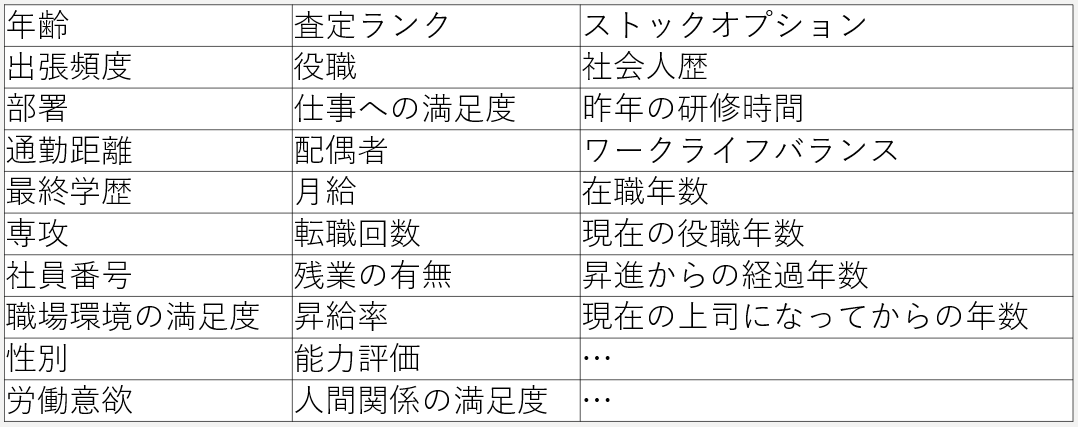

* **補足**：なお、このデータは本物ではなく、IBMのデータサイエンティストが、トレーニング用に作成してくれたものです（ありがたく使わせていただきましょう）
* **参照**：[IBM HR Analytics Employee Attrition & Performance | Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset)

### 0.1 日本語の文字化け（□□□）を訂正


In [ ]:
# 日本語フォントをダウンロードする。
! apt-get -y install fonts-ipafont-gothic

# キャッシュを削除する。
# 削除すべきキャッシュのファイル名は、Matplotlibがバージョンアップすると変わるため、
# 下記のrmでうまく行かない場合、! ls -ll /root/.cache/matplotlib/ でファイル名を確認
# 旧ファイル名：! rm /root/.cache/matplotlib/fontList.json
# 旧ファイル名：! rm /root/.cache/matplotlib/fontlist-v300.json

! rm /root/.cache/matplotlib/fontlist-v310.json   # 2019/10/31段階でのファイル名

### 0.2 ランタイムの再起動

日本語フォントを反映させるため、このタイミングでランタイムを再起動してから、  

→**再起動の方法：Colabメニュー → ランタイム → ランタイムを再起動**　　

再起動後に以降のセルを実行してください

In [ ]:
# 日本語フォントの設定
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

# memo
# plot時に↓のようにフォントを指定する方法もある
# jp_font = {'fontname':'IPAGothic'}
# plt.title('住宅価格のヒストグラム', **jp_font)

-------------

## 1 ライブラリの読み込み
解析に使用するライブラリをインポートします。これは毎回、行う処理ですが、慣れるまでは「最初に唱えるおまじない」程度に思っていても大丈夫です（だんだんと慣れていきましょう）

In [ ]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt   # グラフ描画ライブラリ
import seaborn as sns             # 可視化ライブラリ

# マジックコマンド
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# sns.set(font="TakaoPGothic")

from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')

# 画像サイズの設定
plt.rcParams['figure.figsize'] = (10, 6)

------------

## 2 データセット読み込み
解析対象となる約1500名分の社員データを入手します。

事前に弊社のサーバ上にアップロードしておきましたので、それをダウンロードして使いたいと思います。


#### wgetでデータをダウンロード

In [ ]:
# wgetはウェブサーバからコンテンツを取得するダウンロードコマンドです
! wget https://nai-lab.com/practice/dataset/ibm_hr_dataset_jp.csv

### 2.1 データ読み込み
ダウンロードしたデータを、Pythonの変数（データフレームという種類の変数を使っています）に格納して、最初の5件を表示してみます。

In [ ]:
# 学習用データの読み込み
df_employee = pd.read_csv('/content/ibm_hr_dataset_jp.csv')
df_employee.head()

**補足**：なお、ここでデータを格納している変数の名称は「df_employee」としています。dfは「データフレーム」の略、employeeは「社員」の意味ですが、変数名は作者が自由に付けることができます（が、あまり自由に付けすぎても、他の人が見たときに大変になるので、通常はわかり易いように配慮して名付けします）

ちなみに、head()のカッコ内に数値を入力すると、表示する件数を指定することができます。※(100)なら、冒頭から100件を表示します。

In [ ]:
# 冒頭の10件を表示
df_employee.head(10)

**重要**：一番左側の「Yes」か「No」が入っている列が、退職の有無を表しています。この「Yes」か「No」を、機械学習には教えずに（隠した状態で）、予測をさせることで、それがどれだけ良い精度で予測できるかが、機械学習（AI）に求められる性能です。

### 2.2 データフレームの行・列数の確認
`shape` というメソッド（機能）を使うと、変数（データフレーム）に格納されているデータの、行数（件数）と、列数（項目数）が確認できます。

In [ ]:
print('訓練用データ', df_employee.shape)

- 訓練用データは1470行、29列のデータであることがわかります。

### 2.3 データ型の確認
データをサラッと見ただけだと、「整数型だと思っていたら実は小数型だった」といった思い違いが発生することがあります。この手の誤解は、分析時に思わぬ不具合を引き起こすことがありますので、念の為に各列（項目）のデータがどんな型なのかを、`dtypes`というメソッド（機能）で調べてみます。

In [ ]:
df_employee.dtypes.to_frame()

すべてint64型（整数）か、object型（少し特殊な型。一般的には文字が格納されていることが多い）の、どちらかであることが分かりました。もし小数型がある場合は、floatと表示されますが、今回のデータには小数型はないようです。

- データ型についての公式ドキュメント：https://docs.python.org/ja/3/library/stdtypes.html

### 2.4 欠損値の処理
欠損値とは何らかの理由で値が欠損していることです。理由は様々ですが、例えばアンケート調査で空欄のままになっている項目などに発生します。欠損値を無視して学習を進めてしまうと、モデルの精度低下を引き起こす恐れがありますので、欠損値に適切な対処を施すことが重要になります。

まずは、データの中に欠損値がないかを、`isnull`というメソッド（機能）を使って調べてみましょう。

In [ ]:
df_employee.isnull().sum().to_frame()

**注釈**：幸いなことに、どの項目にも欠損値は含まれていませんでした。

-------------

## 3 前処理
データの前処理とは、データを機械学習モデルに学習させる前に行う処理のことで、料理で例えるならば具材の「下ごしらえ」です。下ごしらえの良し悪しで料理の味（分析結果）も劇的に変化します。

データ分析の分野では「前処理が8割」という言葉をよく見かけます。実際に分析をやり始めるとこの言葉の通り「欠損値をどう埋めるか？」「他の特徴量（説明変数）を生成した方がいいのでは？」など、ほとんどの時間を前処理に費やすことになります。

### 3.1 数値以外の列を確認

機械学習による学習・予測に用いるデータは、原則として数値である必要があります（仮に文字だとしても、何らかの方法で数値化します）

前にデータ型を確認したところ、今回のデータでは以下の列が数値（int64）ではなく、文字（object）が格納されていました。

* 出張頻度
* 部署
* 専攻
* 性別
* 役職
* 配偶者
* 残業の有無

### 3.2 値の出現頻度を確認
まずは、それぞれの列にどのような値が格納されているのかを、`value_counts()`というメソッド（機能）を使って確認してみましょう。

In [ ]:
# 出張頻度の値（と個数）を調べる
df_employee['出張頻度'].value_counts()

In [ ]:
# 部署の値（と個数）を調べる
df_employee['部署'].value_counts()

In [ ]:
# 専攻の値（と個数）を調べる
df_employee['専攻'].value_counts()

#### 演習①：列の値を調べる
以下のプログラムの空欄を埋めて、「性別」「役職」「配偶者」「残業の有無」の各列に存在する値と、それぞれの個数を出力するプログラムを完成させましょう。

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####

# 性別の値（と個数）を調べる
df_employee[■空欄■].value_counts()

######################################################

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####

# 役職の値（と個数）を調べる
df_employee[■空欄■].value_counts()

######################################################

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####

# 配偶者の値（と個数）を調べる
df_employee['配偶者'].■空欄■

######################################################

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####

# 残業の値（と個数）を調べる
df_employee['残業の有無'].■空欄■

######################################################

### 3.3 グラフで可視化
グラフを使って可視化することで、データに対して、よりイメージが湧きやすくなります。ここでは予測対象となる「退職」の列を、棒グラフで表してみましょう。



#### 予測対象（目的変数）となる「退職」の可視化

In [ ]:
# seabornのcountplotを用いて棒グラフで可視化
sns.countplot(x='退職', data=df_employee) # xに列名を指定する
plt.show()

**補足**：たった2行で、あっという間に棒グラフが完成しました。この手軽さもPythonの魅力です。とはいえ、ちょっと味気ないグラフなので、少しだけ装飾してみましょう。

In [ ]:
# seabornのcountplotを用いて棒グラフで可視化
sns.countplot(x='退職', data=df_employee) # xに列名を指定する
plt.title('退職者/雇用者')
plt.ylabel('人')
plt.xticks([0,1], ['退職者', '雇用者'])
plt.show()

**注釈**：退職者が200名前後に対して、雇用者（退職していない人）がその6倍ほどいることが、グラフで確認できました。数値を見るだけではイメージが湧きにくい場合は、こうしてグラフで可視化して確認することも有効です。

### 演習②：様々なグラフ

以下のプログラムの空欄を埋めて、雇用中（退職の列が'No'の人）と、退職済（退職の列が'Yes'の人）の割合を**円グラフ**で表示しましょう。

ヒント：Matplotlibの機能を使用します。詳しくは以下のURLを参照してください

参考：[MatplotlibとSeabornで円グラフを描く | プログラマーになった 「中卒」 男のブログ](https://chusotsu-program.com/matplotlib-pie/)

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####
plt.■空欄■(df_employee['退職'].value_counts(), labels=['雇用中', '退職済'])

続いて、月給の分布を、**ヒストグラム**で表示しましょう。

* ヒント：seabornの機能を使用します。詳しくは以下のURLを参照してください。

* 参考：[seaborn 徹底入門！Pythonを使って手軽で綺麗なデータ可視化８連発](https://www.codexa.net/seaborn-python/)

In [ ]:
##### 演習：以下の■空欄■にプログラムを記入せよ #####
sns.■空欄■(df_employee['月給'])

**注釈**：ヒストグラムで月給を確認すると2000（単位はドルでしょうから、日本円にして20万円前後）のところに、大きなボリュームがあることが分かります。


---
## 演習③：まとめの考察
ここまでの演習で、退職予測に使用するデータセットを、ざっくりと俯瞰しました。振り返りになりますが、以下の28項目をもとに、「退職しそうな人」と「退職しなさそうな人」を予想するのが、この後に続くミッションです。

* 年齢	
* 出張頻度	
* 部署	
* 通勤距離	
* 最終学歴	
* 専攻	
* 社員番号	
* 職場環境の満足度	
* 性別	
* 労働意欲	
* 査定ランク	
* 役職	
* 仕事への満足度	
* 配偶者	
* 月給	
* 転職回数	
* 残業の有無	
* 昇給率	
* 能力評価	
* 人間関係の満足度
* ストックオプション	
* 社会人歴	
* 昨年の研修時間	
* ワークライフバランス	
* 在職年数	
* 現在の役職年数	
* 昇進からの経過年数	
* 現在の上司になってからの年数


さて、これらの項目（説明変数）の中で、あなたは、どの要素が「退職」に関係がある（強い）と思いますか？

１位から３位まで、それぞれ理由も含めて、お答えください。


- １位：
- 理由：

- ２位：
- 理由：

- ３位：
- 理由：

---
## 演習④：まとめの発展
人事部の上司から、「退職する可能性が高い社員に対して、引き止めの面談をしたいので、約1500名の社員の中から、まずは可能性の高そうな100名をピックアップしてほしい」と言われました（なかなか気の重い仕事ですね）

さて、あなたなら、どのようなルール（方法）で、この100名をピックアップしますか？（辞めるつもりが全く無かった社員を、面談に呼び出してしまうと、その後の関係が不穏になるかもしれません。どうぞ慎重に…）

---